In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import edunn as nn
from edunn import utils

# Gradient Descent

Gradient descent is a simple but effective optimization technique for training differentiable models.

In each iteration of the algorithm, we calculate the derivative of the error with respect to each parameter `δEδp`, and update the weights in the opposite direction of the gradient. This update is mediated by the `α` parameter, which indicates the learning rate.

The gradient descent algorithm is simple:

```python
for i in range(iterations):
    for p in model.parameters()
        # Use p[:] to modify the values of p
        # and not create a new variable
        p[:] = p - α * δEδp(x, y)
```

This pseudocode omits some cumbersome parts. In particular, the iteration over the input values `x` and output values `y` of the examples in their batched version, and the calculation of the error and derivatives `δEδp`.

The `edunn` library includes the `BatchedGradientOptimizer` class, which takes care of these aspects and allows us to implement an optimizer very simply by creating a subclass of it and implementing the `optimize_batch` method. In this method, we only need to focus on optimizing the model using the gradients calculated with a batch of the dataset.

For this exercise, we have created the `GradientDescent` class, which subclasses `BatchedGradientOptimizer`. Implement the crucial part of the `optimize_batch` method of `GradientDescent` to update the parameters based on the precomputed gradients.

To test this optimizer, we will use a fake model and fake error that allow us to control the input to the optimizer. The flexibility of the `Model` class in `edunn` makes it very easy to do this by creating the `FakeModel` and `FakeError` classes, which effectively ignore their inputs and outputs and only serve to initialize 2 parameters with values 0 and return `[1, -1]` as derivatives for them.

In [2]:
# Fake model with a parameter vector with an initial value of [0,0] and gradients that are always [1,-11]
model = nn.FakeModel(parameter=np.array([0,0]), gradient=np.array([1, -1]))
# Fake error function whose error is always 1 and derivatives are also 1
error = nn.FakeError(error=1, derivative_value=1)

# Fake dataset, which won't actually be used
fake_samples = 3
fake_x = np.random.rand(fake_samples, 10)
fake_y = np.random.rand(fake_samples, 5)

# Optimize the model for 1 epoch with lr=2
optimizer = nn.GradientDescent(batch_size=fake_samples, epochs=1, lr=2, shuffle=False)
history = optimizer.optimize(model, fake_x, fake_y, error, verbose=False)
expected_parameters = np.array([-2, 2])
utils.check_same(expected_parameters, model.get_parameters()["parameter"])

# Optimize the model for an *additional* 1 epoch with lr=2
history = optimizer.optimize(model, fake_x, fake_y, error, verbose=False)
expected_parameters = np.array([-4, 4])
utils.check_same(expected_parameters, model.get_parameters()["parameter"])
    
# Optimize the model for 3 more epochs, now with lr=1    
optimizer = nn.GradientDescent(batch_size=fake_samples, epochs=3, lr=1, shuffle=False)
history = optimizer.optimize(model, fake_x, fake_y, error, verbose=False)
expected_parameters = np.array([-7, 7])
utils.check_same(expected_parameters, model.get_parameters()["parameter"])

SUCCESS :) Arrays are equal (tolerance 1e-12)
SUCCESS :) Arrays are equal (tolerance 1e-12)
SUCCESS :) Arrays are equal (tolerance 1e-12)


# Training a Linear Regression Model with Gradient Descent

Now that we have all the elements, we can define and train our first `LinearRegression` model to estimate house prices using the Boston Housing dataset.

Dataset sizes: (506, 13) (506, 1)


optim. LinearRegression_0:   0%|          | 0/1000 [00:00<?, ?it/s]

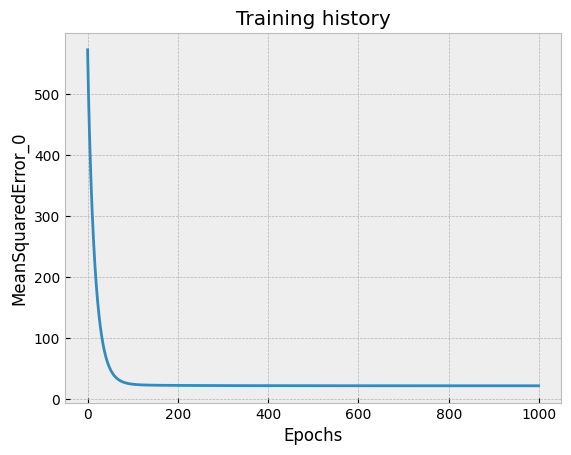

Model Error:
RMSE 3.267849284324999
MAE 3.267849284324999


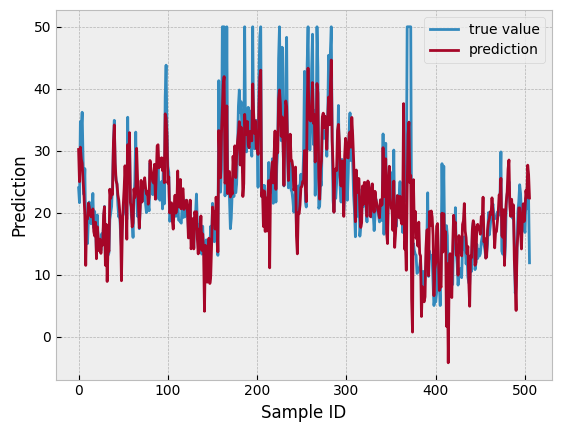

In [3]:
import edunn as nn
import numpy as np
from edunn import metrics, datasets

x, y = datasets.load_regression("boston")
x = (x - x.mean(axis=0)) / x.std(axis=0)
n, din = x.shape
n, dout = y.shape
print("Dataset sizes:", x.shape, y.shape)

# Network with two linear layers
model = nn.LinearRegression(din, dout)
error = nn.MeanError(nn.SquaredError())
optimizer = nn.GradientDescent(lr=0.001, epochs=1000, batch_size=32)

# Optimization algorithm
history = optimizer.optimize(model, x, y, error)
nn.plot.plot_history(history, error_name=error.name)


print("Model Error:")
y_pred = model.forward(x)
metrics.regression_summary(y, y_pred)
nn.plot.regression1d_predictions(y, y_pred)

# Comparison with sklearn

As an additional verification, we will calculate the optimal parameters for a linear regression model using sklearn and visualize the results. The error should be similar to our model's error (RMSE=3.27 or 3.28).

Scikit Learn Model Error:
RMSE 3.2708628109003155
MAE 3.2708628109003155



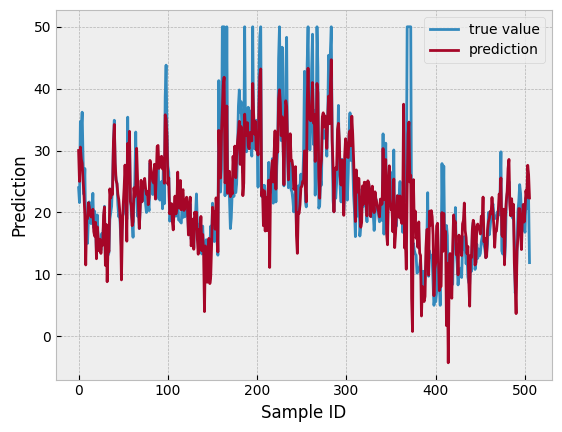

In [6]:
!pip install scikit-learn

from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
print("Scikit Learn Model Error:")
metrics.regression_summary(y, y_pred)
print()

nn.plot.regression1d_predictions(y, y_pred)
